### Attacking Machine Learning Models: Wie Poisoning ein Vorhersagemodell unbrauchbar machen kann
Dieses Notebook gehört zu einem <a href='https://datenverknoten.de/?p=731' target='_blank'>Blogartikel</a> auf <a href='https://www.datenverknoten.de' target='_blank'>datenverknoten.de</a>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
import requests

Zunächst werden Daten mit einer Normalverteilung um 179,9 cm (Körpergröße) und 106 cm (Brustumfang) simuliert. Anschließend werden beide Verteilungen geplottet.

In [2]:
# Normalverteilung der Größe mit Mittelwert 179,9 cm und Standardabweichung von 10 (cm)
training_data_height = np.random.normal(loc=179.9,size=250,scale=10)
# Normalverteilung des Brustumfangs mit Mittelwert 106 cm und Standardabweichung von 5 (cm)
training_data_chest = np.random.normal(loc=106,size=250,scale=5)

[Text(0.5, 0, 'Chest circumference [cm]')]

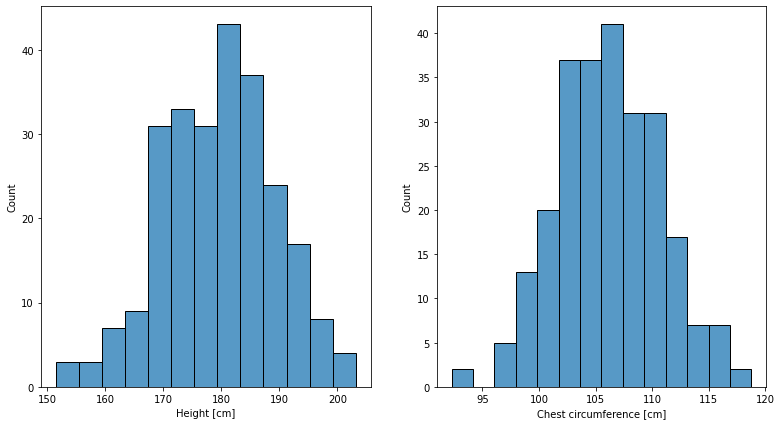

In [3]:
# hier beide verteilungen plotten
f, axes = plt.subplots(1, 2, figsize=(13, 7))

sns.histplot(training_data_height, ax=axes[0])
sns.histplot(training_data_chest, ax=axes[1])

axes[0].set(xlabel="Height [cm]")
axes[1].set(xlabel="Chest circumference [cm]")

In [4]:
# Beide Normalverteilungen in einen Pandas Dataframe speichern
initial_trainingframe = pd.DataFrame({'Height':training_data_height,'ChestCircumference':training_data_chest})

Die Visualisierung im Streudiagramm zeigt, dass die Daten gleichmäßig verteilt sind.

<AxesSubplot:xlabel='Height', ylabel='ChestCircumference'>

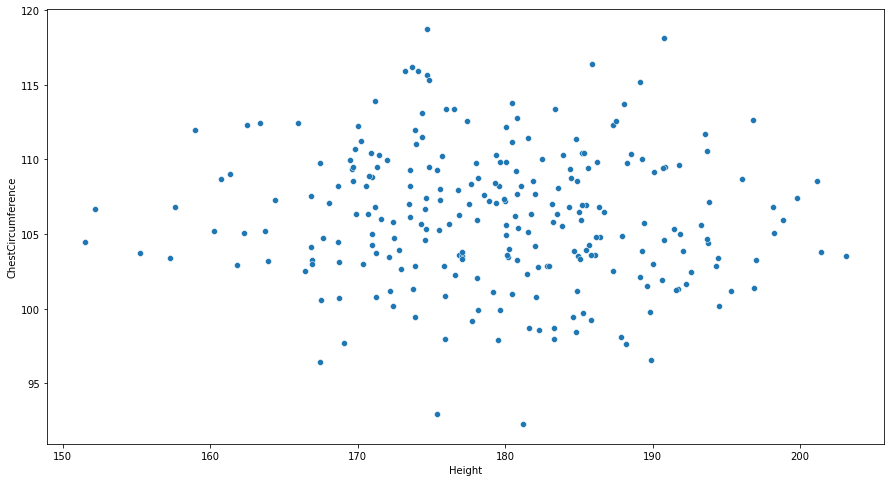

In [5]:
# Verteilung der Daten im Streudiagramm
plt.figure(figsize=(15,8))
sns.scatterplot(data=initial_trainingframe,x='Height',y='ChestCircumference')

Als nächstes wird eine Funktion definiert, welche die Daten auf ungewöhnliche Werte filtert. Dies soll einen Minimalschutz gegen 
Angriffe simulieren. Außerdem wird ein KMeans Modell mit drei Klassen trainiert, welches die Daten in drei unterschiedliche Größen (L,XL und XXL) einteilt. Es wird dabei davon ausgegangen, dass sich die Daten linear trennen lassen. Eine Kombination der Größe und Brustumfang ist in der Wirklichkeit so linear wahrscheinlich nicht zu finden. Für diese Betrachtung hilft die Vereinfachung aber, die Auswirkungen des Datenshiftes zu sehen.

In [6]:
def prepareData(data):
    # Daten filtern, die größer oder kleiner als die zweifache Standardabweichung pro Feature sind
    print("Starting with: "+str(len(data)))
    data = (
        data[
            # Filterung auf ungewöhnliche Werte
            (data['Height'] <= 250) &\
            (data['Height'] >= 130) &\
            (data['ChestCircumference'] >= 70) &\
            (data['ChestCircumference'] <= 160)
        ]
    )

    data = (
        data[
            # Filterung auf statistisch ungewöhnliche Werte
            (data['Height'] <= data['Height'].mean() + data['Height'].std() * 2) &\
            (data['Height'] >= data['Height'].mean() - data['Height'].std() * 2) &\
            (data['ChestCircumference'] <= data['ChestCircumference'].mean() + data['ChestCircumference'].std() * 2) &\
            (data['ChestCircumference'] >= data['ChestCircumference'].mean() - data['ChestCircumference'].std() * 2)
        ]
    )
    print("After filter: "+str(len(data)))
    
    # KMeans Modell fitten
    kmeanscluster = KMeans(n_clusters=3, random_state=0).fit(\
                     [[x] for x in data['ChestCircumference']*data['Height']]
                    )

    # Cluster bestimmen
    data['Cluster'] = kmeanscluster.predict(\
                     [[x] for x in data['ChestCircumference']*data['Height']]
                    )

    # Die Reihenfolge der Clusternummerierung bestimmen. Das kleinste
    # Zentrum steht an nullter Stelle. (Muss gemacht werden, da die
    # Reihenfolge der Cluster umgedreht sein kann und das Mapping
    # von Größe auf Clusternummer ebenfalls umgedreht wird).
    # Die Ausgabe von cluster_centers_ ist geordnet (0,1,2,3...)

    l1 = [x[0] for x in kmeanscluster.cluster_centers_]
    center_indices = ([l1.index(x) for x in sorted(l1)])
    mapping = {center_indices[0]:'L', center_indices[1]:'XL', center_indices[2]:'XXL'}
    # Mapping der Größer auf die Clusternummer
    data['Size'] = data['Cluster'].map(mapping)
    return data

Als nächstes ist also die Verteilung der Kleidergrößen zu sehen, die unter der vereinfachten Annahme einer linearen Abhängigkeit von Kleidergröße und Körpergröße + Brustumfang angenommen wurde.

Starting with: 250
After filter: 227


<AxesSubplot:xlabel='Height', ylabel='ChestCircumference'>

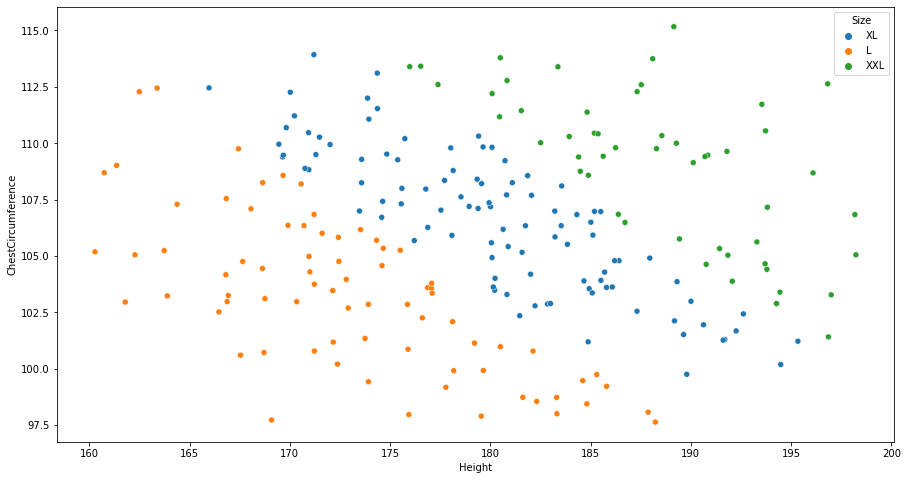

In [7]:
# Verteilung der Daten im Streudiagramm mit Klassen
plt.figure(figsize=(15,8))
sns.scatterplot(data=prepareData(initial_trainingframe),x='Height',y='ChestCircumference', hue='Size')

## Die Vergiftung

Zu diesem Zeitpunkt muss der FittingServer gestartet sein, damit die Endpunkte erreicht werden können. Anpassungen an der Adresse und des Ports können in der nächsten Zelle erfolgen.

In [8]:
address = '127.0.0.1'
port = '5055'

Es werden drei Vorhersagen mit dem auf einer Normalverteilung-basierenden Modell erstellt

In [9]:
print(requests.get("http://"+str(address)+":"+str(port)+"/predict?height=170&circ=103").text)
print(requests.get("http://"+str(address)+":"+str(port)+"/predict?height=180&circ=103").text)
print(requests.get("http://"+str(address)+":"+str(port)+"/predict?height=190&circ=105").text)

{"Prediction":"L"}
{"Prediction":"XL"}
{"Prediction":"XXL"}


Es folgt die Identifizierung der Grenzen für die Vorhersage. In der Praxis würde nur ein schlecht konfigurierter Server so viele Anfragen in so kurzer Zeit von einer IP-Adresse erlauben. Dieser wird für das Austesten der Grenze angenommen.

In [10]:
# Über den Endpunkt data_statistics rufen wir die Mittelwerte (2,4) und Standardabweichungen (3,5) des aktuellen Datensatzes ab.
# Dieser ist die Basis für das Modelltraining. Eine Veränderung in seinen Eigenschaften bedeutet auch eine 
# Veränderung des Modells.
requests.get("http://"+str(address)+":"+str(port)+"/data_statistics").text

'<p>[253, 179.36713902632437, 10.198417763029937, 105.84300437103362, 5.221220920661772]</p>'

In [11]:
# Die Grenzen des Modells austesten mit brute force. Es werden systematisch mögliche Körpergrößen und Brustumfänge ausprobiert
valid_height = []
valid_circ = []
for i in range(160,230):
    for j in range(80,140):
        r = requests.get("http://"+str(address)+":"+str(port)+"/predict?height="+str(i)+"&circ="+str(j))
        if("Error" not in r.text):
            valid_height.append(i)
            valid_circ.append(j)

In [12]:
# Die Grenzen sind nun bekannt.
print(min(valid_height))
print(max(valid_height))
print(min(valid_circ))
print(max(valid_circ))

160
210
94
120


In [13]:
# Durch das Austesten der Grenzen haben sich ggf. die Mittelwerte bereits geändert (2,4). 
requests.get("http://"+str(address)+":"+str(port)+"/data_statistics").text

'<p>[1630, 184.12569703905524, 14.261898169638274, 106.82041724286594, 7.461541151524735]</p>'

Im nächsten Schritt wird das Modell durch gezieltes Abfragen in einem kleinen Wertebereich beeinflusst.

In [14]:
# Das Modell soll nach oben verzerrt werden, deswegen werden jetzt 500 requests in diesem Bereich geschickt.
# Dadurch wird ein Neutrainieren erzwungen
bias_heigth_data = np.random.normal(loc=205,size=500,scale=3)
bias_circ_data = np.random.normal(loc=115,size=500,scale=3)
for i in range(0,len(bias_heigth_data)):
    requests.get("http://"+str(address)+":"+str(port)+"/predict?height="+str(bias_heigth_data[i])+"&circ="+str(bias_circ_data[i]))

In [15]:
# Erneut rufen wir die Statistik ab. Auch hier ist wieder zu sehen, dass sich ggf. die Mittelwerte der Daten verändert haben.
requests.get("http://127.0.0.1:"+str(port)+"/data_statistics").text

'<p>[2101, 188.79247280628385, 15.334558187299221, 108.54626561596447, 7.416694199912173]</p>'

In [16]:
# Nun soll das Modell noch stärker verzerrt werden. Es werden 1000 requests geschickt und damit wird das Modell zwei Mal trainiert.
bias_heigth_data = np.random.normal(loc=205,size=1000,scale=3)
bias_circ_data = np.random.normal(loc=115,size=1000,scale=3)
for i in range(0,len(bias_heigth_data)):
    requests.get("http://"+str(address)+":"+str(port)+"/predict?height="+str(bias_heigth_data[i])+"&circ="+str(bias_circ_data[i]))

In [17]:
# Wieder schauen wir uns die Mittelwerte an. Sie sind nun deutlich größer geworden.
requests.get("http://"+str(address)+":"+str(port)+"/data_statistics").text

'<p>[3027, 193.66369704604784, 14.815407895006791, 110.43756461456219, 6.964290139423697]</p>'

Die letzte, große Abfrage sorgt dafür, dass die ursprünglichen Daten komplett von den verzerrten Daten verdrängt werden.

In [18]:
# Eine weitere Runde der Verzerrung, dieses mal jedoch mit 10000 Instanzen und ca. 20 Retrainings
# Die ursprünglichen Daten werden nicht mehr im Training verwendet, da nur die neusten 10000 Instanzen
# vom Modell berücksichtigt werden.
bias_heigth_data = np.random.normal(loc=205,size=10000,scale=2)
bias_circ_data = np.random.normal(loc=115,size=10000,scale=2)
for i in range(0,len(bias_heigth_data)):
    requests.get("http://"+str(address)+":"+str(port)+"/predict?height="+str(bias_heigth_data[i])+"&circ="+str(bias_circ_data[i]))

In [19]:
# Die Vorhersagen sind nun abweichend, da die verzerrten Daten den überwiegenden Teil im DataFrame, der für das Training 
# verwendet wird, einnehmen. Das Modell ist damit durch einen Datendrift unbrauchbar.
print(requests.get("http://"+str(address)+":"+str(port)+"/predict?height=170&circ=103").text)
print(requests.get("http://"+str(address)+":"+str(port)+"/predict?height=180&circ=103").text)
print(requests.get("http://"+str(address)+":"+str(port)+"/predict?height=190&circ=105").text)

{"Prediction":"L"}
{"Prediction":"L"}
{"Prediction":"L"}


In [20]:
# Auch die Mittelwerte des DataFrames zeigen eine deutliche Abweichung im Vergleich zu vorher.
requests.get("http://"+str(address)+":"+str(port)+"/data_statistics").text

'<p>[12967, 202.33419086810702, 8.79148348784804, 113.93484025067437, 4.246747611603229]</p>'